# ---------------------------------- XAI2 - EDM 2025 ----------------------------------

### Team members:

1. Ole Magnus Lærum
2. Piotr Franc


### Team group ID
EDM_ETSINF_34

### Imports


In [7]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree


## Task 1 - Logistic Regression

In [8]:
## ------------------------------------------------------ Preprocessing ------------------------------------------------------

dataframe = pd.read_csv('datasets/compas-scores-two-years.csv')

print("Shape of the original dataframe:", dataframe.shape)

# Filter out -30 > days_b_screening_arrest > 30
filtered_df = dataframe[
    (dataframe['days_b_screening_arrest'] >= -30) 
    & (dataframe['days_b_screening_arrest'] <= 30) 
    & (dataframe['race'].isin(['African-American', 'Caucasian']))].copy()

# Make a binary variable, if decile_score >= 4
filtered_df.loc[:, 'recidivist'] = (filtered_df['decile_score'] > 4).astype(int)

# To show that the data is correctly filtered:
print("Shape of the filtered dataframe:", filtered_df.shape)
printing_coloumns = list(filtered_df.columns[:1]) + ['days_b_screening_arrest'] + ['race'] + ['recidivist'] + ['decile_score']
print(filtered_df[printing_coloumns].iloc[35:46])

Shape of the original dataframe: (7214, 53)
Shape of the filtered dataframe: (5278, 54)
    id  days_b_screening_arrest              race  recidivist  decile_score
47  68                      0.0         Caucasian           0             1
49  70                      0.0  African-American           0             4
50  71                    -24.0         Caucasian           0             2
54  79                     -1.0  African-American           1             5
55  80                     -1.0  African-American           0             4
57  84                     -1.0  African-American           0             1
58  85                    -13.0         Caucasian           1             5
59  87                     -1.0  African-American           0             3
61  90                     -1.0  African-American           1            10
62  91                     -1.0         Caucasian           0             2
63  93                     -1.0  African-American           0             4


In [9]:
## ------------------------------------------------------ Logistic Regression to predict Recedivism ------------------------------------------------------

# Make binary variables for race and sex
categorical_dummies = pd.get_dummies(filtered_df[['sex','race']], drop_first=True)

df_model = pd.concat([
    filtered_df[['age','is_recid']], 
    categorical_dummies,
], axis=1)

# Find f(x) = y
X = sm.add_constant(df_model).astype(float) 
y = filtered_df['recidivist']
y = y.astype(float)

print("-------------- X dataframe: --------------\n")
print(X.head())

# Train model - using binomial family logistic regression
model = sm.GLM(y, X, family=sm.families.Binomial())
result = model.fit()

# Find results
summary_table = pd.DataFrame({
    'Coefficient': result.params,  #resulting weights - beta-values
    'Odds Ratio': np.exp(result.params),
    'Std. Error': result.bse
})

print("\n -------------- Summary: --------------\n")
print(summary_table)

-------------- X dataframe: --------------

    const   age  is_recid  sex_Male  race_Caucasian
1     1.0  34.0       1.0       1.0             0.0
2     1.0  24.0       1.0       1.0             0.0
6     1.0  41.0       1.0       1.0             1.0
8     1.0  39.0       0.0       0.0             1.0
10    1.0  27.0       0.0       1.0             1.0

 -------------- Summary: --------------

                Coefficient  Odds Ratio  Std. Error
const              1.326619    3.768282    0.123024
age               -0.048606    0.952557    0.002915
is_recid           1.123086    3.074327    0.061655
sex_Male          -0.049439    0.951764    0.077576
race_Caucasian    -0.769195    0.463386    0.063559


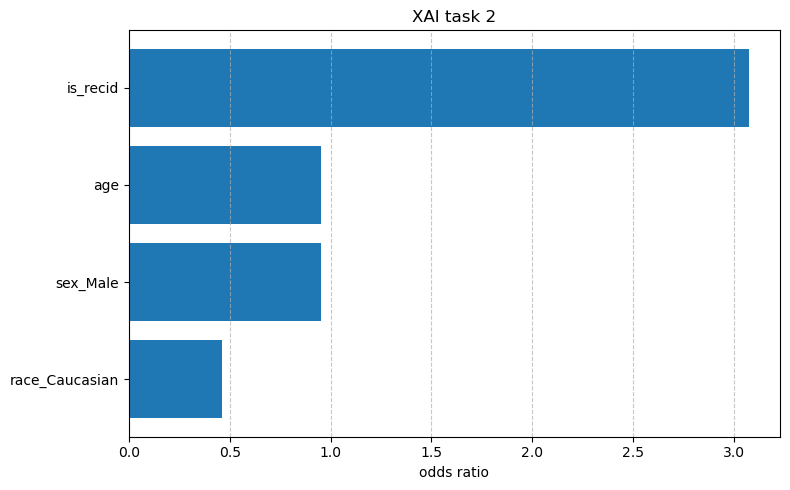

In [10]:
## ------------------------------------------------------ Plotting ------------------------------------------------------

# Remove intercept
plot_df = summary_table.drop(index='const')

# Order bars
plot_df_sorted = plot_df.sort_values(by='Odds Ratio', ascending=True)

plt.figure(figsize=(8, 5))
plt.barh(plot_df_sorted.index, plot_df_sorted['Odds Ratio'])
plt.xlabel('odds ratio')
plt.title('XAI task 2')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Task 2 - Tree

In [11]:
## ------------------------------------------------------ Preprocessing (as done in XAI1 only in python here) ------------------------------------------------------

data_task2= pd.read_csv('datasets/day.csv', sep=',')

data_task2['spring'] = np.where(data_task2['season'] == 2, 1, 0)
data_task2['summer'] = np.where(data_task2['season'] == 3, 1, 0)
data_task2['fall']   = np.where(data_task2['season'] == 4, 1, 0)

data_task2['misty'] = np.where(data_task2['weathersit'] == 2, 1, 0)
data_task2['rain']  = np.where(data_task2['weathersit'].isin([3, 4]), 1, 0)

data_task2['temp']     = data_task2['temp'].astype(float) * 47 - 8
data_task2['hum']      = data_task2['hum'].astype(float) * 100
data_task2['windspeed']= data_task2['windspeed'].astype(float) * 67

data_task2['dteday'] = pd.to_datetime(data_task2['dteday'])
data_task2['days_since_2011'] = (data_task2['dteday'] - pd.Timestamp('2011-01-01')).dt.days

print("First date in the dataset:", data_task2['dteday'].min())

model_data = data_task2[['fall', 'spring', 'summer',  'workingday', 'holiday', 'misty', 'rain',  'temp', 'hum', 'windspeed',  'days_since_2011']]

print(data_task2.head())
print("Shape of the data:", data_task2.shape)

First date in the dataset: 2011-01-01 00:00:00
   instant     dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1 2011-01-01       1   0     1        0        6           0   
1        2 2011-01-02       1   0     1        0        0           0   
2        3 2011-01-03       1   0     1        0        1           1   
3        4 2011-01-04       1   0     1        0        2           1   
4        5 2011-01-05       1   0     1        0        3           1   

   weathersit      temp  ...  windspeed  casual  registered   cnt  spring  \
0           2  8.175849  ...  10.749882     331         654   985       0   
1           2  9.083466  ...  16.652113     131         670   801       0   
2           1  1.229108  ...  16.636703     120        1229  1349       0   
3           1  1.400000  ...  10.739832     108        1454  1562       0   
4           1  2.666979  ...  12.522300      82        1518  1600       0   

   summer  fall  misty  rain  days_since_2011  
0  

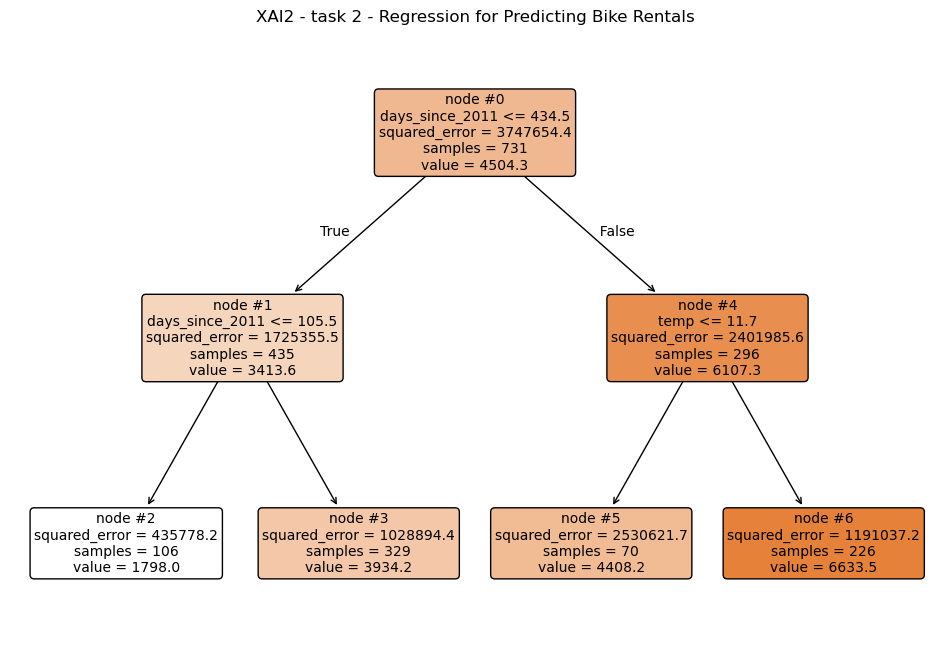

In [12]:

## ------------------------------------------------------ Building a regression tree ------------------------------------------------------

# Find f(x) = y
y = data_task2['cnt']
X = model_data

# train model - using regression tree, no ckit from partykit in Python, but this will make a regression tree as well
tree = DecisionTreeRegressor(max_depth=2, random_state=13)
tree.fit(X, y)

plt.figure(figsize=(12, 8))
plot_tree(
    tree,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    fontsize=10,
    precision=1,
    node_ids=True,
)
plt.title("XAI2 - task 2 - Regression for Predicting Bike Rentals")
plt.show()
